In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
import torch
#from torch.special import erfcx 

In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [4]:
print(np.max(apr_mag_g))
print(np.min(apr_mag_g))
print(np.min(apr_mag_g_err))
print()

24.021461
17.057114
0.000622325



In [5]:
d = Planck18.distmod(z).value

In [6]:
'''
def log_likelihood(params,apr_mag, magerr, d, k, m_lim):
    # Filter arrays based on the limiting magnitude
    sigma_I, M_X = params[0],params[1]
    additional_params = params[2:apr_mag.shape[0]]
    # Calculate each term of the log-likelihood
    term1 = -np.log(2*np.pi*magerr*sigma_I)
    term2 = -0.5*((apr_mag-params[2:])/magerr)**2
    term3 = -0.5*((apr_mag-d-k-M_X)/sigma_I)**2
    term4 = -np.log(1/2)-np.log(erfc((apr_mag-m_lim)/np.sqrt(2)/magerr))
    total_log_likelihood = np.sum(term1 +term2+term3+term4)
    #print(total_log_likelihood.shape)
    return total_log_likelihood
    '''

'\ndef log_likelihood(params,apr_mag, magerr, d, k, m_lim):\n    # Filter arrays based on the limiting magnitude\n    sigma_I, M_X = params[0],params[1]\n    additional_params = params[2:apr_mag.shape[0]]\n    # Calculate each term of the log-likelihood\n    term1 = -np.log(2*np.pi*magerr*sigma_I)\n    term2 = -0.5*((apr_mag-params[2:])/magerr)**2\n    term3 = -0.5*((apr_mag-d-k-M_X)/sigma_I)**2\n    term4 = -np.log(1/2)-np.log(erfc((apr_mag-m_lim)/np.sqrt(2)/magerr))\n    total_log_likelihood = np.sum(term1 +term2+term3+term4)\n    #print(total_log_likelihood.shape)\n    return total_log_likelihood\n    '

In [7]:
def log_likelihood(params,apr_mag, magerr, d, k, m_lim):
    # Filter arrays based on the limiting magnitude
    sigma_I, M_X = params[0],params[1]
    m_real = params[2:apr_mag.shape[0]+2]
    # Calculate each term of the log-likelihood
    term1 = -torch.log(2*torch.pi*magerr*sigma_I)
    term2 = -0.5*((apr_mag-m_real)/magerr)**2
    term3 = -0.5*((m_real-d-k-M_X)/sigma_I)**2
    term4 = -torch.log(torch.tensor(1/2))-torch.log(erfc((apr_mag-m_lim)/torch.sqrt(torch.tensor(2))/magerr))
    total_log_likelihood = torch.sum(term1 +term2+term3+term4)
    #print(total_log_likelihood.shape)
    return total_log_likelihood

In [8]:
m_lim = 22.5
indice = apr_mag_g < m_lim
apr_mag_g = apr_mag_g[indice]
apr_mag_g_err = apr_mag_g_err[indice]
d = d[indice]
k_gg = k_gg[indice]
#params_1 = np.empty(apr_mag_g.shape[0]+2)
#params_1[0],params_1[1] = 1,-24
#params_1[2:] = 22

In [9]:
#-log_likelihood(params_1,apr_mag_g, apr_mag_g_err , d, k_gg, m_lim)

In [10]:
# Initialize parameters, ensuring they require gradients
params = torch.randn(apr_mag_g.shape[0]+2, requires_grad=True)  # Adjust size according to your total number of parameters

# Define optimizer
optimizer = torch.optim.Adam([params], lr=0.003)

# Convert your data to PyTorch tensors
apr_mag_g_tensor = torch.from_numpy(apr_mag_g.astype(np.float32))
apr_mag_g_err_tensor = torch.from_numpy(apr_mag_g_err.astype(np.float32))
d_tensor = torch.from_numpy(d.astype(np.float32))
k_gg_tensor = torch.from_numpy(k_gg.astype(np.float32))

epochs = []
Losses = []
param0_values = []  # List to track params[0] values
param1_values = []  # List to track params[1] values

# Optimization loop
for epoch in range(100000):  # Adjust number of epochs as needed
    optimizer.zero_grad()
    loss = -log_likelihood(params, apr_mag_g_tensor, apr_mag_g_err_tensor, d_tensor, k_gg_tensor, 22.5)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        params[0].clamp_(0.001,2)#intrinsic dispersion
        params[1].clamp_(-30,-20)#average absolute magnitude

    # Append current loss and parameter values
    epochs.append(epoch)
    Losses.append(loss.item())
    param0_values.append(params[0].item())
    param1_values.append(params[1].item())

    if epoch % 100 == 0:  # Print loss and parameter values every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}, Param0: {params[0].item()}, Param1: {params[1].item()}")

Epoch 0, Loss: nan, Param0: 0.0010000000474974513, Param1: -20.0
Epoch 100, Loss: 923574599680.0, Param0: 0.01876748353242874, Param1: -20.026010513305664
Epoch 200, Loss: 900651286528.0, Param0: 0.019320961087942123, Param1: -20.036481857299805
Epoch 300, Loss: 875621580800.0, Param0: 0.019984811544418335, Param1: -20.049488067626953
Epoch 400, Loss: 850170085376.0, Param0: 0.020707158371806145, Param1: -20.06417465209961
Epoch 500, Loss: 825059770368.0, Param0: 0.021457746624946594, Param1: -20.080039978027344
Epoch 600, Loss: 800617922560.0, Param0: 0.02221865952014923, Param1: -20.096755981445312
Epoch 700, Loss: 776960081920.0, Param0: 0.022979257628321648, Param1: -20.114120483398438
Epoch 800, Loss: 754100797440.0, Param0: 0.02373334765434265, Param1: -20.131988525390625
Epoch 900, Loss: 732009398272.0, Param0: 0.024477416649460793, Param1: -20.15025520324707
Epoch 1000, Loss: 710637584384.0, Param0: 0.025209631770849228, Param1: -20.168861389160156
Epoch 1100, Loss: 68993246822

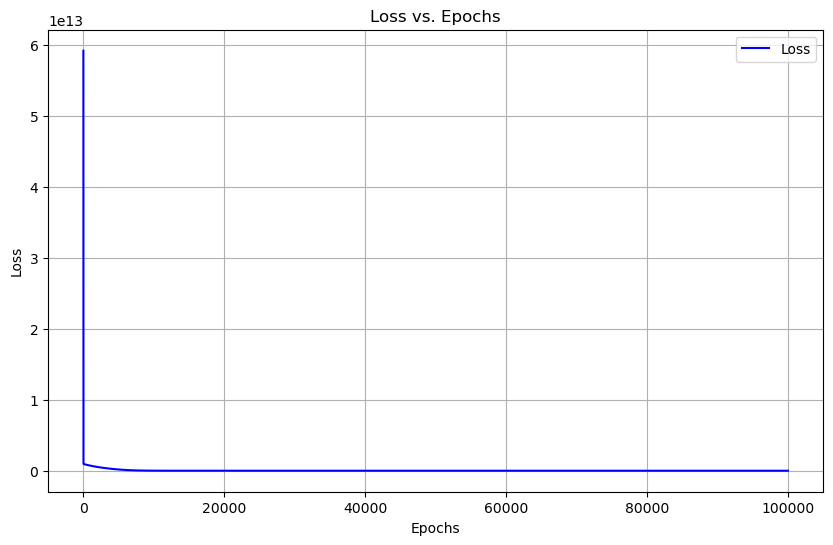

In [11]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, Losses, label='Loss', color='blue')  # Plot Losses vs. epochs
plt.title('Loss vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

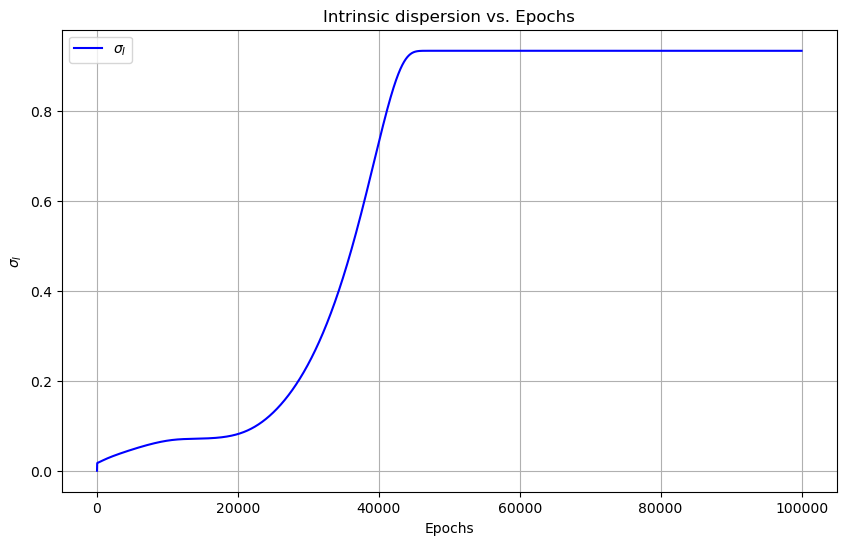

In [12]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param0_values, label='$\sigma_I$', color='blue')  # Plot Losses vs. epochs
plt.title('Intrinsic dispersion vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('$\sigma_I$')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

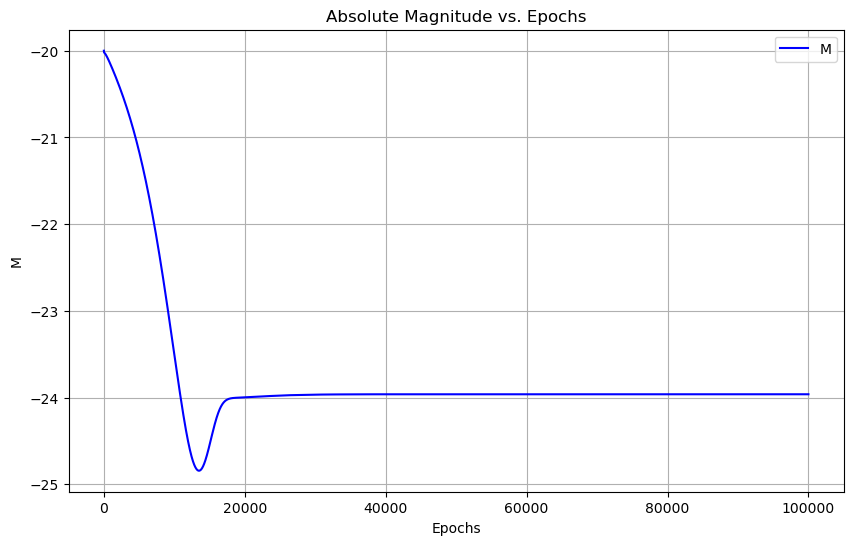

In [13]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, param1_values, label='M', color='blue')  # Plot Losses vs. epochs
plt.title('Absolute Magnitude vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('M')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

In [14]:
# Access optimized parameters
optimized_params = params.data

# If you need to convert to a numpy array for further processing outside PyTorch
optimized_params_numpy = optimized_params.numpy()

print("Optimized Parameters:", optimized_params)
print("As Numpy Array:", optimized_params_numpy)

Optimized Parameters: tensor([  0.9344, -23.9610,  21.4121,  ...,  20.7876,  21.4208,  22.2203])
As Numpy Array: [  0.9343901 -23.961006   21.41212   ...  20.787573   21.420801
  22.220318 ]
